# 01 year simulation

In [1]:
#Step 1: Libraries
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from affine import Affine
import numpy as np
from shapely.geometry import mapping
from shapely.geometry import Point
from collections import defaultdict
import os

from datetime import datetime, timedelta
import glob

from shapely.geometry import Polygon

In [2]:
#Step 2: Define File Paths
hdf_path = r"D:\GMU\RAS_EESLR\2020\09VF.p30.hdf" #sep
aoi_paths = [
    r"D:\GMU\RAS_EESLR\2020\Areas\area1.shp",
    r"D:\GMU\RAS_EESLR\2020\Areas\area2.shp",
    r"D:\GMU\RAS_EESLR\2020\Areas\area3.shp",
    r"D:\GMU\RAS_EESLR\2020\Areas\area4.shp",
    r"D:\GMU\RAS_EESLR\2020\Areas\area5b.shp",
    r"D:\GMU\RAS_EESLR\2020\Areas\area6.shp"
]

In [3]:
#Step 3: Load AOI shapefiles and combine them into a single GeoDataFrame
# Load and tag each AOI with a label
aoi_list = []
for i, path in enumerate(aoi_paths, start=1):
    gdf = gpd.read_file(path)
    gdf["Area"] = f"Area {i}"
    aoi_list.append(gdf)

# Combine all AOIs into one GeoDataFrame
all_aois = gpd.GeoDataFrame(pd.concat(aoi_list, ignore_index=True), crs=aoi_list[0].crs)

# Display summary
print(f"✅ Loaded {len(all_aois)} AOIs:")
print(all_aois[["Area"]])


✅ Loaded 6 AOIs:
     Area
0  Area 1
1  Area 2
2  Area 3
3  Area 4
4  Area 5
5  Area 6


In [ ]:
# --- Step 4 (Polygon Version): Load HEC-RAS cell polygons from HDF ---

from shapely.geometry import Polygon

with h5py.File(hdf_path, "r") as hdf:
    # All vertex coordinates
    face_coords = hdf["Geometry/2D Flow Areas/VA20230620195713/FacePoints Coordinate"][:]
    # Mapping of which facepoints belong to each cell
    cell_face_indexes = hdf["Geometry/2D Flow Areas/VA20230620195713/Cells FacePoint Indexes"][:]

# Build polygons for each cell
cell_polygons = []
for face_ids in cell_face_indexes:
    # Filter valid indices (>= 0)
    pts = [tuple(face_coords[i]) for i in face_ids if i >= 0]
    if len(pts) >= 3:
        cell_polygons.append(Polygon(pts))
    else:
        cell_polygons.append(None)

# GeoDataFrame of polygons
cells_gdf = gpd.GeoDataFrame(
    {"cell_id": range(len(cell_polygons))}, #This labels cells as 0, 1, 2, … directly from Python. In HECRAS needs to add+1 in cell number
    geometry=cell_polygons,
    crs=all_aois.crs
)

print(f"✅ Loaded {len(cells_gdf)} cell polygons.")



✅ Loaded 625148 cell polygons.



📋 Intersecting Cell Summary:
     Area  Intersecting Cells
0  Area 1                  16
1  Area 2                   7
2  Area 3                   9
3  Area 4                   9
4  Area 5                   6
5  Area 6                   8


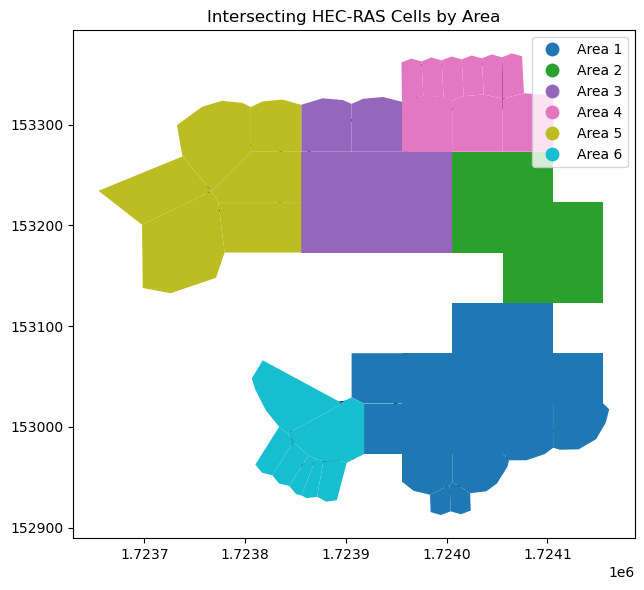

In [7]:
#Step 4b: Match cells to AOIs and summarize intersecting cells
# --- Initialize summaries ---
summary_rows = []
intersecting_cells_all = []

# --- Loop through each AOI polygon ---
for idx, aoi_row in all_aois.iterrows():
    area_label = aoi_row['Area']
    single_aoi = gpd.GeoDataFrame([aoi_row], crs=all_aois.crs)

    # Spatial join: find cells that intersect with AOI
    cells_in_aoi = gpd.sjoin(cells_gdf, single_aoi, how='inner', predicate='intersects')
    n_cells = len(cells_in_aoi)

    # Save results
    summary_rows.append({"Area": area_label, "Intersecting Cells": n_cells})
    cells_in_aoi['Area'] = area_label
    intersecting_cells_all.append(cells_in_aoi)

# --- Combine into final GeoDataFrame ---
intersecting_cells_gdf = pd.concat(intersecting_cells_all, ignore_index=True)
intersecting_cells_gdf = gpd.GeoDataFrame(intersecting_cells_gdf, crs=all_aois.crs)

# --- Show summary ---
summary_df = pd.DataFrame(summary_rows)
print("\n📋 Intersecting Cell Summary:")
print(summary_df)

# --- Optional: plot ---
fig, ax = plt.subplots(figsize=(10, 6))
all_aois.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=2)
intersecting_cells_gdf.plot(ax=ax, column='Area', legend=True, markersize=10)
plt.title("Intersecting HEC-RAS Cells by Area")
plt.tight_layout()
plt.show()


In [8]:
# --- Step 4c: Print coordinates of intersecting cells only ---
with h5py.File(hdf_path, 'r') as hdf:
    coords = hdf['Geometry/2D Flow Areas/VA20230620195713/Cells Center Coordinate'][:]

# Extract coordinates for intersecting cells
used_cell_ids = intersecting_cells_gdf['cell_id'].unique()
used_coords = coords[used_cell_ids]

# Print coordinates for each used cell
print("📍 Coordinates of Intersecting HEC-RAS Cells:")
for i, cid in enumerate(used_cell_ids):
    x, y = coords[cid]
    print(f"Cell {cid}: X = {x:.2f}, Y = {y:.2f}")

# Show bounding box for used cells
x_min, y_min = used_coords.min(axis=0)
x_max, y_max = used_coords.max(axis=0)

print(f"\n📐 Used Cell Coordinate Bounds:")
print(f"X: [{x_min:.2f}, {x_max:.2f}]")
print(f"Y: [{y_min:.2f}, {y_max:.2f}]")


📍 Coordinates of Intersecting HEC-RAS Cells:
Cell 429649: X = 1724030.71, Y = 153097.99
Cell 429650: X = 1724080.71, Y = 153097.99
Cell 430005: X = 1723930.71, Y = 153047.99
Cell 430006: X = 1723980.71, Y = 153047.99
Cell 430007: X = 1724030.71, Y = 153047.99
Cell 430008: X = 1724080.71, Y = 153047.99
Cell 430009: X = 1724130.71, Y = 153047.99
Cell 430366: X = 1723930.71, Y = 152997.99
Cell 430367: X = 1723980.71, Y = 152997.99
Cell 430368: X = 1724030.71, Y = 152997.99
Cell 430369: X = 1724080.71, Y = 152997.99
Cell 430370: X = 1724130.71, Y = 152997.99
Cell 430728: X = 1723980.71, Y = 152947.99
Cell 430729: X = 1724030.71, Y = 152947.99
Cell 620093: X = 1723993.92, Y = 152920.71
Cell 620094: X = 1724013.83, Y = 152921.44
Cell 428580: X = 1724030.71, Y = 153247.99
Cell 428581: X = 1724080.71, Y = 153247.99
Cell 428933: X = 1724030.71, Y = 153197.99
Cell 428934: X = 1724080.71, Y = 153197.99
Cell 428935: X = 1724130.71, Y = 153197.99
Cell 429291: X = 1724080.71, Y = 153147.99
Cell 4292

In [9]:
# --- Step 5: Load WSE, terrain, and timestamps (read directly from HDF) ---
with h5py.File(hdf_path, 'r') as hdf:
    # Water Surface Elevation: (ntimes, ncells)
    wse = hdf['Results/Unsteady/Output/Output Blocks/Base Output/Unsteady Time Series/2D Flow Areas/VA20230620195713/Water Surface'][:] #at central cell

    # Terrain elevation per cell
    terrain = hdf['Geometry/2D Flow Areas/VA20230620195713/Cells Minimum Elevation'][:]

    # Timestamps (byte strings like b'01JUN2020 00:00:00')
    raw_times = hdf['Results/Unsteady/Output/Output Blocks/Base Output/Unsteady Time Series/Time Date Stamp'][:]
    timestamps = [pd.to_datetime(t.decode('utf-8'), format="%d%b%Y %H:%M:%S") for t in raw_times]

# ✅ Sanity check
print(f"✅ WSE shape: {wse.shape} (ntimes, ncells)")
print(f"✅ Terrain shape: {terrain.shape} (ncells)")
print(f"✅ First 10 timestamps: {timestamps[:10]}")


✅ WSE shape: (60, 625148) (ntimes, ncells)
✅ Terrain shape: (625148,) (ncells)
✅ First 10 timestamps: [Timestamp('2020-09-01 00:00:00'), Timestamp('2020-09-01 12:00:00'), Timestamp('2020-09-02 00:00:00'), Timestamp('2020-09-02 12:00:00'), Timestamp('2020-09-03 00:00:00'), Timestamp('2020-09-03 12:00:00'), Timestamp('2020-09-04 00:00:00'), Timestamp('2020-09-04 12:00:00'), Timestamp('2020-09-05 00:00:00'), Timestamp('2020-09-05 12:00:00')]


In [10]:
# --- Step 6: Flood analysis by Area (using pre-generated timestamps) --- Depth(t,cell)=WSE(t,cell)−MinElev(cell)

flow_area_name = "VA20230620195713"  # replace with your actual 2D Flow Area name from HEC-RAS
# Output folder
output_folder = os.getcwd()

# Threshold for considering a cell flooded (depth in ft)
depth_threshold = 0.0328084  # Change if needed 1cm

print("🔎 Starting flood analysis for each AOI...\n")

# Loop over each AOI
for area_name in intersecting_cells_gdf["Area"].unique():
    # Filter cells for this AOI
    area_cells = intersecting_cells_gdf[intersecting_cells_gdf["Area"] == area_name]
    cell_ids = area_cells["cell_id"].values
    print(f"🔎 Analyzing flooding for {area_name} with {len(cell_ids)} cells...\n")

    # Prepare records for this AOI
    flood_records = []

    # Loop through timesteps using pre-generated timestamps
    for t_idx, timestamp in enumerate(timestamps):
        wse_t = wse[t_idx, cell_ids]
        terrain_t = terrain[cell_ids]
        depth = wse_t - terrain_t
        # Store depth for each cell
        record = {"Datetime": timestamp}
        for c_idx, cell_id in enumerate(cell_ids):
            record[f"Cell_{cell_id}"] = max(depth[c_idx], 0)  # no negatives
        flood_records.append(record)

    # Convert to DataFrame
    flood_df = pd.DataFrame(flood_records)

    # Save CSV per area
    csv_path = os.path.join(output_folder, f"flood_depths_{area_name}.csv")
    flood_df.to_csv(csv_path, index=False)
    print(f"📄 Saved: {csv_path}")

print("✅ Flood analysis complete.")


🔎 Starting flood analysis for each AOI...

🔎 Analyzing flooding for Area 1 with 16 cells...

📄 Saved: c:\Github\Lab_work\Pocomoke\one_year_simulation\flood_depths_Area 1.csv
🔎 Analyzing flooding for Area 2 with 7 cells...

📄 Saved: c:\Github\Lab_work\Pocomoke\one_year_simulation\flood_depths_Area 2.csv
🔎 Analyzing flooding for Area 3 with 9 cells...

📄 Saved: c:\Github\Lab_work\Pocomoke\one_year_simulation\flood_depths_Area 3.csv
🔎 Analyzing flooding for Area 4 with 9 cells...

📄 Saved: c:\Github\Lab_work\Pocomoke\one_year_simulation\flood_depths_Area 4.csv
🔎 Analyzing flooding for Area 5 with 6 cells...

📄 Saved: c:\Github\Lab_work\Pocomoke\one_year_simulation\flood_depths_Area 5.csv
🔎 Analyzing flooding for Area 6 with 8 cells...

📄 Saved: c:\Github\Lab_work\Pocomoke\one_year_simulation\flood_depths_Area 6.csv
✅ Flood analysis complete.


In [11]:
# --- Step 7: Flood / No‑Flood analysis from Step 6 CSVs ---

# ========= Inputs =========
# Folder where Step 6 saved per‑area files like: flood_depths_Area_1.csv
input_folder  = os.getcwd()
output_folder = os.getcwd()

# Detection pattern for Step 6 exports
pattern = os.path.join(input_folder, "flood_depths_*.csv")

# Flood threshold (ft). Use your preferred value:
depth_threshold = 0.0328084 # 0.033 ft ≈ 0.0328084 ft ≈ 1 cm
eps = 1e-6  # to avoid floating noise right at the cutoff

# ========= Collect & combine per‑area CSVs (long/tidy) =========
all_long = []  # rows: Area, Datetime, cell_id, Depth_ft

for fpath in sorted(glob.glob(pattern)):
    # Derive Area name from filename (matches how Step 6 wrote them)
    # e.g., "flood_depths_Area 1.csv" -> "Area 1"
    fname = os.path.basename(fpath)
    area_name = os.path.splitext(fname)[0].replace("flood_depths_", "")
    
    # Read Step 6 file
    df = pd.read_csv(fpath, parse_dates=["Datetime"])

    # Melt wide -> long: keep Datetime, gather Cell_* columns
    cell_cols = [c for c in df.columns if c.lower().startswith("cell_")]
    if not cell_cols:
        print(f"⚠️  No cell columns found in {fname}; skipping.")
        continue

    long = df.melt(id_vars=["Datetime"], value_vars=cell_cols,
                   var_name="Cell_Col", value_name="Depth_ft")
    # Recover numeric cell ID (Cell_12345 -> 12345)
    long["cell_id"] = long["Cell_Col"].str.replace("Cell_", "", regex=False).astype(int)
    long = long.drop(columns=["Cell_Col"])

    # Attach Area name
    long.insert(0, "Area", area_name)

    all_long.append(long)

if not all_long:
    raise RuntimeError("No Step 6 files found or no cell columns detected. Check `input_folder` and file names.")

depth_long = pd.concat(all_long, ignore_index=True)
depth_long = depth_long.sort_values(["Area", "Datetime", "cell_id"]).reset_index(drop=True)

# ========= Hourly/timestep flooding (per Area, per Datetime) =========
depth_long["Flooded"] = depth_long["Depth_ft"] > (depth_threshold + eps)

hourly = (depth_long
          .groupby(["Area", "Datetime"], as_index=False)
          .agg(Flooded_Cells=("Flooded", "sum")))
hourly["Any_Flooding"] = hourly["Flooded_Cells"] > 0

# Save hourly table
hourly_csv = os.path.join(output_folder, "flood_hourly_events.csv")
hourly.to_csv(hourly_csv, index=False)
print(f"📄 Saved hourly flood events to: {hourly_csv}")


📄 Saved hourly flood events to: c:\Github\Lab_work\Pocomoke\one_year_simulation\flood_hourly_events.csv


In [12]:
# ========= Daily summary (per Area, per Date) =========
hourly["Date"] = hourly["Datetime"].dt.date
daily = (hourly
         .groupby(["Area", "Date"], as_index=False)
         .agg(Flooded_Intervals=("Any_Flooding", "sum")))
# A day is considered "flooded" if ≥1 of its 12‑hr intervals flooded
daily["Flooded"] = daily["Flooded_Intervals"] > 0

daily_csv = os.path.join(output_folder, "flood_daily_summary.csv")
daily.to_csv(daily_csv, index=False)
print(f"📄 Saved daily summary to: {daily_csv}")


📄 Saved daily summary to: c:\Github\Lab_work\Pocomoke\one_year_simulation\flood_daily_summary.csv


# Sanity check

In [13]:
import h5py
import numpy as np
import pandas as pd

In [14]:
def print_hdf_structure(hdf_file, path, indent=0):
    with h5py.File(hdf_file, "r") as f:
        def _print(name, obj):
            print("  " * indent + name)
        f[path].visititems(_print)

#hdf_path = r"D:\GMU\RAS_EESLR\2020\09VF.p30.hdf"
base_path = "Geometry/2D Flow Areas/VA20230620195713"
print_hdf_structure(hdf_path, base_path)

Cells Center Coordinate
Cells Center Manning's n
Cells Face and Orientation Info
Cells Face and Orientation Values
Cells FacePoint Indexes
Cells Minimum Elevation
Cells Surface Area
Cells Volume Elevation Info
Cells Volume Elevation Values
FacePoints Cell Index Values
FacePoints Cell Info
FacePoints Coordinate
FacePoints Face and Orientation Info
FacePoints Face and Orientation Values
FacePoints Is Perimeter
Faces Area Elevation Info
Faces Area Elevation Values
Faces Cell Indexes
Faces FacePoint Indexes
Faces Low Elevation Centroid
Faces Minimum Elevation
Faces NormalUnitVector and Length
Faces Perimeter Info
Faces Perimeter Values
Infiltration
Infiltration/Abstraction Ratio
Infiltration/Cell Center Classifications
Infiltration/Curve Number
Infiltration/Face Center Classifications
Infiltration/Minimum Infiltration Rate
Infiltration/Properties
Perimeter


In [15]:
def print_hdf_structure(hdf_file, path, indent=0):
    with h5py.File(hdf_file, "r") as f:
        def _print(name, obj):
            print("  " * indent + name)
        f[path].visititems(_print)

#hdf_path = r"D:\GMU\RAS_EESLR\2020\09VF.p30.hdf"
base_path = "/Results/Unsteady/Output/Output Blocks/Base Output/Unsteady Time Series/2D Flow Areas"
print_hdf_structure(hdf_path, base_path)

VA20230620195713
VA20230620195713/Boundary Conditions
VA20230620195713/Boundary Conditions/BC Line 1
VA20230620195713/Boundary Conditions/BC Line 1 - Flow per Face
VA20230620195713/Boundary Conditions/BC Line 1 - Stage per Face
VA20230620195713/Cell Cumulative Excess Depth
VA20230620195713/Cell Cumulative Infiltration Depth
VA20230620195713/Cell Cumulative Precipitation Depth
VA20230620195713/Computations
VA20230620195713/Computations/Inner Iteration Number
VA20230620195713/Computations/Inner Max Volume Residual
VA20230620195713/Computations/Inner Max Volume Residual Cell
VA20230620195713/Computations/Max Face Velocity
VA20230620195713/Computations/Max Face Velocity Face
VA20230620195713/Computations/Max Water Surface
VA20230620195713/Computations/Max Water Surface Cell
VA20230620195713/Computations/Min Water Surface
VA20230620195713/Computations/Min Water Surface Cell
VA20230620195713/Computations/Outer Iteration Number
VA20230620195713/Computations/Outer Max Water Surface Correction


In [17]:
# === Verify if cell IDs are 1-based ===
check_cell = 430006
check_time = pd.Timestamp("2020-09-01 00:00:00")

# find index in your timestamps array
try:
    t_idx = int(np.where(pd.to_datetime(timestamps) == check_time)[0][0])
except IndexError:
    raise ValueError("Timestamp 2020-01-25 12:00:00 not found in 'timestamps'.")

# get number of cells to sanity-check bounds
ncells = terrain.shape[0]

def safe(idx):
    return None if idx < 0 or idx >= ncells else float(wse[t_idx, idx] - terrain[idx])

depth_0based   = safe(check_cell)       # assumes your IDs are already 0-based
depth_1based   = safe(check_cell - 1)   # assumes your IDs are 1-based labels


print("Depth if treated as 0-based index: ", depth_0based)
print("Depth if treated as 1-based label:", depth_1based)


Depth if treated as 0-based index:  0.0
Depth if treated as 1-based label: 0.7083128690719604


In [25]:
# pick the correct array index after Step B:
correct_idx = 430006  # or python x and hecras x+1

# find timestamp index
t_target = pd.Timestamp("2020-09-01 00:00:00")
t_idx = int(np.where(pd.to_datetime(timestamps) == t_target)[0][0])

print("Time check:", timestamps[t_idx])

wse_val = float(wse[t_idx, correct_idx])
z_val   = float(terrain[correct_idx])
depth_val = wse_val - z_val

print(f"WSE: {wse_val:.6f} ft, Terrain: {z_val:.6f} ft, Depth: {depth_val:.6f} ft")

# also print a small window around that time
win = 10
rows = []
for k in range(max(0, t_idx-win), min(len(timestamps), t_idx+win+1)):
    rows.append([timestamps[k], float(wse[k, correct_idx]-terrain[correct_idx])])
pd.DataFrame(rows, columns=["Timestamp","Depth_ft"])


Time check: 2020-09-01 00:00:00
WSE: 2.049917 ft, Terrain: 2.049917 ft, Depth: 0.000000 ft


,Timestamp,Depth_ft
0,2020-09-01 00:00:00,0.000000
1,2020-09-01 12:00:00,0.000000
2,2020-09-02 00:00:00,0.000000
3,2020-09-02 12:00:00,0.000000
4,2020-09-03 00:00:00,0.000000
5,2020-09-03 12:00:00,0.000000
6,2020-09-04 00:00:00,0.000000
7,2020-09-04 12:00:00,0.000000
8,2020-09-05 00:00:00,0.000000
9,2020-09-05 12:00:00,0.008523


In [27]:
# pick the correct array index after Step B:
correct_idx = 430005  # or python x and hecras x+1

# find timestamp index
t_target = pd.Timestamp("2020-09-01 00:00:00")
t_idx = int(np.where(pd.to_datetime(timestamps) == t_target)[0][0])

print("Time check:", timestamps[t_idx])

wse_val = float(wse[t_idx, correct_idx])
z_val   = float(terrain[correct_idx])
depth_val = wse_val - z_val

print(f"WSE: {wse_val:.6f} ft, Terrain: {z_val:.6f} ft, Depth: {depth_val:.6f} ft")

# also print a small window around that time
win = 10
rows = []
for k in range(max(0, t_idx-win), min(len(timestamps), t_idx+win+1)):
    rows.append([timestamps[k], float(wse[k, correct_idx])])
pd.DataFrame(rows, columns=["Timestamp","wse_ft"])


Time check: 2020-09-01 00:00:00
WSE: 1.810000 ft, Terrain: 1.101687 ft, Depth: 0.708313 ft


,Timestamp,wse_ft
0,2020-09-01 00:00:00,1.810000
1,2020-09-01 12:00:00,1.245559
2,2020-09-02 00:00:00,1.270019
3,2020-09-02 12:00:00,1.270019
4,2020-09-03 00:00:00,1.270019
5,2020-09-03 12:00:00,1.270019
6,2020-09-04 00:00:00,1.270019
7,2020-09-04 12:00:00,1.270019
8,2020-09-05 00:00:00,1.270019
9,2020-09-05 12:00:00,1.283804


✅ Saved: depth_multiple_cells.csv


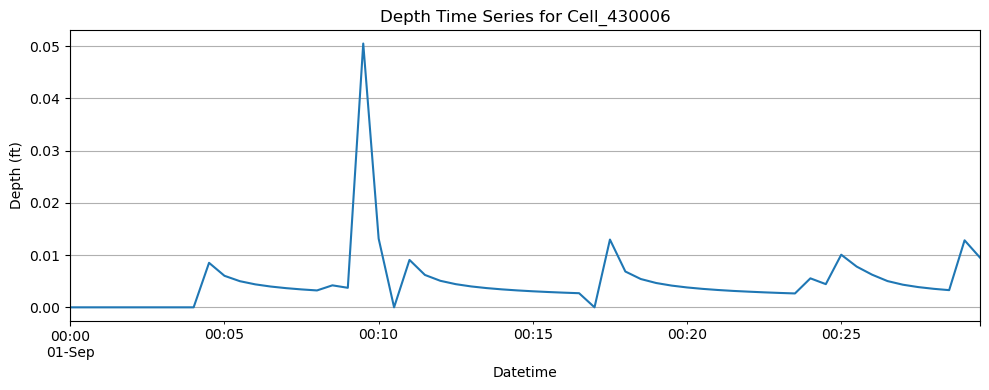

In [48]:
#plot cell depht time series

# === USER INPUTS ===
#hdf_path = r"D:\GMU\RAS_EESLR\2020\01VF.p05.hdf"
cell_ids = [430006]  # Replace with your actual cell IDs

# === OPEN HDF FILE ===
with h5py.File(hdf_path, 'r') as f:
    # 1. Get time info
    time_minutes = f['/Results/Unsteady/Output/Output Blocks/Base Output/Unsteady Time Series/Time'][:]
    start_str = f['/Results/Unsteady/Output/Output Blocks/Base Output/Unsteady Time Series/Time Date Stamp'][0].decode()
    start_datetime = datetime.strptime(start_str, '%d%b%Y %H:%M:%S')
    time_index = [start_datetime + timedelta(minutes=float(t)) for t in time_minutes]

    # 2. Get full water surface matrix (time_steps x num_cells)
    ws_all = f['/Results/Unsteady/Output/Output Blocks/Base Output/Unsteady Time Series/2D Flow Areas/VA20230620195713/Water Surface'][:]

    # 3. Get all cell minimum elevations
    z_all = f['/Geometry/2D Flow Areas/VA20230620195713/Cells Minimum Elevation'][:]

    # 4. Build depth dataframe
    depth_data = {}
    for cid in cell_ids:
        ws = ws_all[:, cid]
        z = z_all[cid]
        depth = ws - z
        depth_data[f'Cell_{cid}'] = depth

# === CREATE FINAL DATAFRAME ===
depth_df = pd.DataFrame(depth_data, index=pd.to_datetime(time_index))
depth_df.index.name = 'Datetime'

# === SAVE TO CSV ===
depth_df.to_csv('depth_multiple_cells.csv')
print("✅ Saved: depth_multiple_cells.csv")

#PLOT EACH CELL'S DEPTH TIME SERIES

for col in depth_df.columns:
    plt.figure(figsize=(10, 4))
    depth_df[col].plot(title=f'Depth Time Series for {col}', ylabel='Depth (ft)', xlabel='Datetime')
    plt.grid(True)
    plt.tight_layout()
    #plt.savefig(f'{col}_depth_plot.png')  # Optional: Save each plot as PNG
    plt.show()

In [46]:
print(depth_df.to_csv.__defaults__)  # Check default path argument
print("File saved at:", os.path.abspath('depth_multiple_cells.csv'))

None
File saved at: c:\Github\Lab_work\Pocomoke\one_year_simulation\depth_multiple_cells.csv
